In [17]:
#Import necessary libraries
import pandas as pd
from tsfresh import extract_features
import matplotlib.pyplot as plt
import os
import datetime
import time
from collections import OrderedDict
import math
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from tsfresh.examples import load_robot_execution_failures
from tsfresh.transformers import RelevantFeatureAugmenter

In [18]:
#Create extraction headers for the dataset 
header = ['session_num', 'student_id', 'exercise_id', 'activity', 'start_time', 
'end_time', 'idle_time_ms', 'mouse_wheel', 'mouse_wheel_clicks', 'mouse_clicks_left', 
'mouse_clicks_right', 'mouse_movements', 'keystrokes']

#Create pandas dataframe
df = pd.read_csv("EPM Dataset.csv", names=header)
df

,session_num,student_id,exercise_id,activity,start_time,end_time,idle_time_ms,mouse_wheel,mouse_wheel_clicks,mouse_clicks_left,mouse_clicks_right,mouse_movements,keystrokes
0,1,1,Es,Other,2.10.2014 11:25:33,2.10.2014 11:25:34,0.0,0,0,0,0,84,0
1,1,1,Es,Aulaweb,2.10.2014 11:25:35,2.10.2014 11:25:42,218.0,0,0,4,0,397,0
2,1,1,Es,Blank,2.10.2014 11:25:43,2.10.2014 11:25:43,0.0,0,0,0,0,59,0
3,1,1,Es,Deeds,2.10.2014 11:25:44,2.10.2014 11:26:17,154117.0,6,0,8,0,1581,4
4,1,1,Es,Other,2.10.2014 11:26:18,2.10.2014 11:26:18,0.0,0,0,2,0,103,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
230313,6,99,Es_6_3,Aulaweb,11.12.2014 13:47:30,11.12.2014 13:47:35,60.0,30,0,1,0,250,0
230314,6,99,Es_6_3,Other,11.12.2014 13:47:36,11.12.2014 13:47:36,0.0,0,0,3,0,37,0
230315,6,99,Es_6_3,Other,11.12.2014 13:47:37,11.12.2014 13:47:39,64.0,0,0,2,2,283,0
230316,6,99,Es_6_3,FSM_Es_6_3,11.12.2014 13:47:40,11.12.2014 13:47:40,0.0,0,0,2,0,67,0


In [19]:
#Convert times to unix-style to avoid errors in time
df["datetime_start_time"] = pd.to_datetime(df["start_time"])
df["datetime_end_time"] = pd.to_datetime(df["end_time"])
df["time_delta"] = abs((df["datetime_start_time"] - df["datetime_end_time"]).dt.total_seconds())
print(df.head())


   session_num  student_id exercise_id  activity           start_time  \
0            1           1          Es     Other   2.10.2014 11:25:33   
1            1           1          Es   Aulaweb   2.10.2014 11:25:35   
2            1           1          Es     Blank   2.10.2014 11:25:43   
3            1           1          Es     Deeds   2.10.2014 11:25:44   
4            1           1          Es     Other   2.10.2014 11:26:18   

              end_time  idle_time_ms  mouse_wheel  mouse_wheel_clicks  \
0   2.10.2014 11:25:34           0.0            0                   0   
1   2.10.2014 11:25:42         218.0            0                   0   
2   2.10.2014 11:25:43           0.0            0                   0   
3   2.10.2014 11:26:17      154117.0            6                   0   
4   2.10.2014 11:26:18           0.0            0                   0   

   mouse_clicks_left  mouse_clicks_right  mouse_movements  keystrokes  \
0                  0                   0         

In [20]:
#Isolate colums into dataframe to detect errors in data (Focus on time_delta)
df_extracted_time = df[["student_id", "time_delta"]]
print(df_extracted_time.head())

   student_id  time_delta
0           1         1.0
1           1         7.0
2           1         0.0
3           1        33.0
4           1         0.0


In [21]:
#Isolate colums into dataframe to detect errors in data (Focus on mouse clicks)
df_extracted_mouse_clicks = df[["student_id", "mouse_clicks_left", "mouse_clicks_right", "mouse_wheel_clicks"]]
print(df_extracted_mouse_clicks.head())


   student_id  mouse_clicks_left  mouse_clicks_right  mouse_wheel_clicks
0           1                  0                   0                   0
1           1                  4                   0                   0
2           1                  0                   0                   0
3           1                  8                   0                   0
4           1                  2                   0                   0


In [22]:
#Isolate colums into dataframe to detect errors in data (Focus on mouse wheel)
df_extracted_mouse_wheel = df[["student_id", "mouse_wheel"]]
print(df_extracted_mouse_wheel.head())


   student_id  mouse_wheel
0           1            0
1           1            0
2           1            0
3           1            6
4           1            0


In [26]:
#Isolate colums into dataframe to detect errors in data (Focus on mouse movements)
df_extracted_mouse_movements = df[["student_id", "mouse_movements"]]
print(df_extracted_mouse_movements.head())
df

   student_id  mouse_movements
0           1               84
1           1              397
2           1               59
3           1             1581
4           1              103


,session_num,student_id,exercise_id,activity,start_time,end_time,idle_time_ms,mouse_wheel,mouse_wheel_clicks,mouse_clicks_left,mouse_clicks_right,mouse_movements,keystrokes,datetime_start_time,datetime_end_time,time_delta
0,1,1,Es,Other,2.10.2014 11:25:33,2.10.2014 11:25:34,0.0,0,0,0,0,84,0,2014-02-10 11:25:33,2014-02-10 11:25:34,1.0
1,1,1,Es,Aulaweb,2.10.2014 11:25:35,2.10.2014 11:25:42,218.0,0,0,4,0,397,0,2014-02-10 11:25:35,2014-02-10 11:25:42,7.0
2,1,1,Es,Blank,2.10.2014 11:25:43,2.10.2014 11:25:43,0.0,0,0,0,0,59,0,2014-02-10 11:25:43,2014-02-10 11:25:43,0.0
3,1,1,Es,Deeds,2.10.2014 11:25:44,2.10.2014 11:26:17,154117.0,6,0,8,0,1581,4,2014-02-10 11:25:44,2014-02-10 11:26:17,33.0
4,1,1,Es,Other,2.10.2014 11:26:18,2.10.2014 11:26:18,0.0,0,0,2,0,103,0,2014-02-10 11:26:18,2014-02-10 11:26:18,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230313,6,99,Es_6_3,Aulaweb,11.12.2014 13:47:30,11.12.2014 13:47:35,60.0,30,0,1,0,250,0,2014-11-12 13:47:30,2014-11-12 13:47:35,5.0
230314,6,99,Es_6_3,Other,11.12.2014 13:47:36,11.12.2014 13:47:36,0.0,0,0,3,0,37,0,2014-11-12 13:47:36,2014-11-12 13:47:36,0.0
230315,6,99,Es_6_3,Other,11.12.2014 13:47:37,11.12.2014 13:47:39,64.0,0,0,2,2,283,0,2014-11-12 13:47:37,2014-11-12 13:47:39,2.0
230316,6,99,Es_6_3,FSM_Es_6_3,11.12.2014 13:47:40,11.12.2014 13:47:40,0.0,0,0,2,0,67,0,2014-11-12 13:47:40,2014-11-12 13:47:40,0.0


In [31]:
pipeline = Pipeline([
            ('augmenter', RelevantFeatureAugmenter(column_id='student_id')),
            ('classifier', RandomForestClassifier()),
            ])
df_time = df['keystrokes'].squeeze()
df_ts, y = df_extracted_mouse_movements, df_time
X = pd.DataFrame(index=y.index)

pipeline.set_params(augmenter__timeseries_container=df_ts)
pipeline.fit(X, y)

Feature Extraction: 100%|██████████| 20/20 [02:40<00:00,  8.04s/it]
/Users/Achi/opt/anaconda3/lib/python3.8/site-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['mouse_movements__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
# df["time_delta"].index.to_pydatetime()
features_time = extract_features(df_extracted_time, column_id='student_id')


Feature Extraction: 100%|██████████| 20/20 [02:58<00:00,  8.91s/it]


In [ ]:
print(features_time)

     time_delta__variance_larger_than_standard_deviation  \
1                                                  1.0     
2                                                  1.0     
3                                                  1.0     
4                                                  1.0     
5                                                  1.0     
..                                                 ...     
111                                                1.0     
112                                                1.0     
113                                                1.0     
114                                                1.0     
115                                                1.0     

     time_delta__has_duplicate_max  time_delta__has_duplicate_min  \
1                              0.0                            1.0   
2                              0.0                            1.0   
3                              0.0                            1.0   
4  

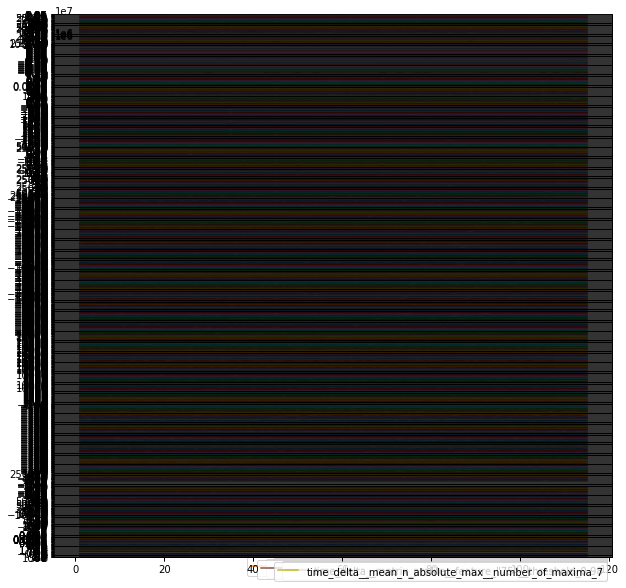

In [ ]:
features_time.plot(subplots=True, sharex=True, figsize=(10,10))
plt.show()

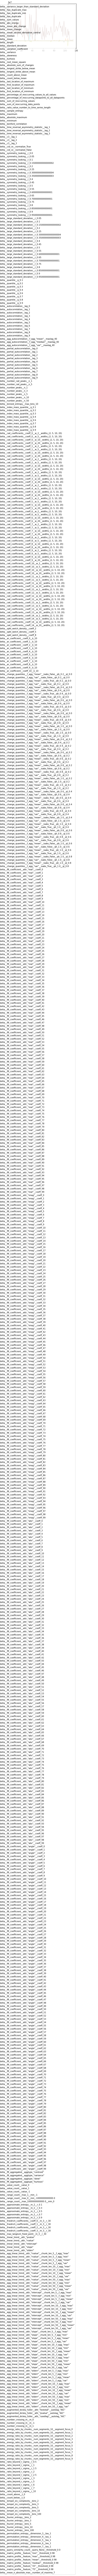

In [ ]:
features.plot()
plt.show()

In [ ]:
features_time[features_time['id'] == 20].plot(subplots=True, sharex=True, figsize=(10,10))
plt.show()

NameError: name 'features_time' is not defined

In [ ]:
from tsfresh import extract_features
extracted_features = extract_features(timeseries, column_id="id", column_sort="time")

In [ ]:
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

impute(extracted_features)
features_filtered = select_features(extracted_features, y)